In [1]:
import sys
import re
import os
import pyart
from copy import deepcopy
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy
from io import StringIO
from boto.s3.connection import S3Connection
import boto
from boto.s3.key import Key
import gzip
import pylab as plb
import matplotlib as mpl
%matplotlib inline
import numpy.ma as ma
import datetime
from datetime import datetime, timedelta

def dt_to_dict(dt, **kwargs):
    pref = kwargs.get('pref', '')
    return dict([(pref+key, getattr(dt, key)) for key in
                ['year', 'month', 'day', 'hour', 'minute', 'second']])

/home/zsherman/anaconda3/lib/python3.5/site-packages/pyart/map/grid_mapper.py:40: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  from .ball_tree import BallTree
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1=

In [2]:
#gzip and opening CPOL files
LOCAL_PATH = '/home/zsherman/Documents/Jupyter/'
filenames = []
conn = S3Connection(anon=True)
bucket = conn.get_bucket('testradar', validate=False)
bucket_list = bucket.list()
for l in bucket_list:
    keyString = str(l.key)
    print(keyString)
    if '.gz' in keyString:
        l.get_contents_to_filename(LOCAL_PATH+keyString)
        filenames.append(LOCAL_PATH+keyString[0:-3])
        gzfh = gzip.open(LOCAL_PATH+keyString, 'rb')
        ofh = open(LOCAL_PATH+keyString[0:-3], 'wb')
        for line in gzfh:
            ofh.write(line)
        ofh.close()
        gzfh.close()
        os.remove(LOCAL_PATH+keyString)

CSU_unfolded/
CSU_unfolded/CPOL_corr_20060122_082009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_083009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_084009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_085009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_090008_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_091008_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_092008_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_093013_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_094009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_095009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_100009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_101009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_102008_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_103009_vt_unfolded_hand.cfrad.nc.gz
CSU_unfolded/CPOL_corr_20060122_10

In [3]:
radar_files = []
for filename in filenames:
    radar_file = pyart.io.read(filename)
    radar_files += [radar_file]

In [4]:
myradar = radar_files[30]

In [5]:
#for filename in filenames:
    #s = re.findall(r'\d+_\d+', filename)[0]
    #datetimes = datetime.strptime(s, '%Y%m%d_%H%M%S')
    #print(datetimes)
s = re.findall(r'\d+_\d+', filenames[30])[0] 
datetimes = datetime.strptime(s, '%Y%m%d_%H%M%S')

In [6]:
def polar_plot(myradar, i, ax, var, **kwargs):
    ax.cla()
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    i_s=myradar.sweep_start_ray_index['data'][i]
    i_e=myradar.sweep_end_ray_index['data'][i]
    order=np.argsort(myradar.azimuth['data'][i_s:i_e])
    theta,rad = np.meshgrid(myradar.azimuth['data'][i_s:i_e][order], 
        myradar.range['data']) #rectangular plot of polar data
    X = theta*np.pi/180.0
    Y = rad/1000.0
    if 'mask' in kwargs.keys():
        pc=ax.pcolormesh(X,Y,np.ma.masked_where( kwargs['mask'][i_s:i_e,:][order,:].transpose(), 
            myradar.fields[var]['data'][i_s:i_e,:][order,:].transpose() ), 
            vmin=kwargs.get('vmin', -6), vmax=kwargs.get('vmax', 64))
    else:
        pc=ax.pcolormesh(X,Y,myradar.fields[var]['data'][i_s:i_e,:][order,:].transpose(), 
            vmin=kwargs.get('vmin', -6), vmax=kwargs.get('vmax', 64))
    ax.set_title(myradar.metadata['instrument_name'] + str(datetimes))
    if 'ylim' in kwargs:
        ylim(kwargs['ylim'])
    plt.grid(True)
    return pc
    #colorbar(mappable=pc)

In [7]:
def interval_mean(data, current_z, wanted_z):
    """ Find the mean of data indexed by current_z
        at wanted_z on intervals wanted_z+/- delta
        wanted_z """
    delta=wanted_z[1]-wanted_z[0]
    pos_lower=[np.argsort( (current_z-(wanted_z[i]-delta/2.0))**2 )[0] 
               for i in range(len(wanted_z))]
    pos_upper=[np.argsort( (current_z-(wanted_z[i]+delta/2.0))**2)[0]
               for i in range(len(wanted_z))]
    new_values=np.array([data[pos_lower[i]:pos_upper[i]].mean() 
               for i in range(len(pos_upper))])
    return new_values
    
def sd_to_uv(speed, direction):
    return (speed*np.sin(direction), speed*np.cos(direction))

def VADf(V,Az,El,Ra):
    '''Calculates VAD for a scan, returns speed and angle 
    outdic=VADf(V,Az,El,Ra) 
    V is 2D array, Az,Ra are 1D arrays, El is number. All in degrees, m
    outdic contains speed,angle,variance'''
    
     
    nrays,nbins=V.shape
    nr2=nrays/2
    Vc=np.empty((nr2,nbins,2))
    Vc[:,:,0]=V[0:nr2,:]
    Vc[:,:,1]=V[nr2:,:]
    sinaz=np.sin(np.radians(Az))
    cosaz=np.cos(np.radians(Az))
    sumv=np.ma.sum(Vc,2)
    vals=np.isnan(sumv)
    vals2=np.vstack((vals,vals))
    count=np.sum(np.isnan(sumv) ==  False,0)
    aa=count<8
    vals[:,aa]=0
    vals2[:,aa]=0
    count=np.float_(count)
    count[aa]=np.nan
    U_m=np.array([np.nansum(sumv,0)/(2*count)])
    count[aa]=0
    
 
    CminusU_mcos=np.zeros((nrays,nbins))
    CminusU_msin=np.zeros((nrays,nbins))
    sincos=np.zeros((nrays,nbins))
    sin2=np.zeros((nrays,nbins))
    cos2=np.zeros((nrays,nbins))
    
    for i in range(nbins):

        CminusU_mcos[:,i]=cosaz*(V[:,i]-U_m[:,i])
      
        CminusU_msin[:,i]=sinaz*(V[:,i]-U_m[:,i])
     
        sincos[:,i]=sinaz*cosaz
        
        sin2[:,i]=sinaz**2
        cos2[:,i]=cosaz**2
    
   
    CminusU_mcos[vals2]=np.nan
    CminusU_msin[vals2]=np.nan
    
    
    sincos[vals2]=np.nan
    sin2[vals2]=np.nan
    cos2[vals2]=np.nan
    sumCminU_mcos=np.nansum(CminusU_mcos,0)
    sumCminU_msin=np.nansum(CminusU_msin,0)
    sumsincos=np.nansum(sincos,0)
    sumsin2=np.nansum(sin2,0)
    sumcos2=np.nansum(cos2,0)
    a=(sumCminU_mcos-(sumsincos*sumCminU_msin/sumsin2))/(sumcos2-(sumsincos**2)/sumsin2)
    b=(sumCminU_msin-a*sumsincos)/sumsin2
    speed=np.sqrt(a**2+b**2)/np.cos(np.radians(El))
    angle=np.arctan2(a,b)   
    
    crv=np.empty((nrays,nbins))
    for i in range(nbins):
        crv[:,i]=np.sin(np.radians(Az)+angle[i])*speed[i]
    Vn=V.copy()
    Vn[vals2==True]=np.nan
    S=np.nansum((crv-Vn)**2,0)/(sum(np.isnan(Vn)==False)-2)
    return {'speed':speed,'angle':angle,'variance':S}

def VAD(myradar, z_want):
    speed=[]
    angle=[]
    height=[]
    
   
    
    x = myradar.gate_x['data']
    y = myradar.gate_y['data']
    z = myradar.gate_z['data']

    
    for i in range(len(myradar.sweep_start_ray_index['data'])):
        i_s=myradar.sweep_start_ray_index['data'][i]
        i_e=myradar.sweep_end_ray_index['data'][i]
        if (i_e-i_s)%2==0:
            print ("even, all good")
        else:
            i_e=i_e-1
        VR=myradar.fields['CVD']['data'][i_s:i_e, :]
        SQ=myradar.fields['norm_coh_power']['data'][i_s:i_e, :]
        Az=myradar.azimuth['data'][i_s:i_e]
        Ra=myradar.range['data']
        El=myradar.fixed_angle['data'][i]
        
        mask=VR.mask
        
        crud=SQ < 0.5
        VR[np.where(mask)]=np.nan
       
        VR[np.where(crud)]=np.nan
      
        one_level=VADf(VR,Az,El,Ra/1000.0)
  
        
        not_garbage=np.isfinite(one_level['speed'])
       
        print ("max height", z[i_s, :][np.where(not_garbage)].max())
       
        speed.append(one_level['speed'][np.where(not_garbage)])
        angle.append(one_level['angle'][np.where(not_garbage)])
        height.append(z[i_s, :][np.where(not_garbage)])
       
    
    speed_array=np.concatenate(speed)
    angle_array=np.concatenate(angle)
    height_array=np.concatenate(height)
    arg_order=height_array.argsort()
   
    speed_ordered=speed_array[arg_order]
    height_ordered=height_array[arg_order]
    angle_ordered=angle_array[arg_order]
    u_ordered, v_ordered=sd_to_uv(speed_ordered, angle_ordered)
    u_mean=interval_mean(u_ordered, height_ordered, z_want)
    v_mean=interval_mean(v_ordered, height_ordered, z_want)
    return u_mean, v_mean

In [8]:
radar_file.fields.keys()

/home/zsherman/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/zsherman/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


dict_keys(['CVR', 'corrected_differential_reflectivity', 'specific_differential_phase', 'cross_correlation_coefficient', 'VT', 'corrected_velocity', 'CVD', 'velocity', 'reflectivity'])

In [9]:
x = myradar.gate_x['data']
y = myradar.gate_y['data']
z = myradar.gate_z['data']

In [10]:
myradar.add_field_like('reflectivity', 'norm_coh_power',
                    myradar.fields['reflectivity']['data'].copy(),replace_existing = True)

In [11]:
(myradar.fields['norm_coh_power']['data'])[myradar.fields['norm_coh_power']['data'] !=1]=1

In [12]:
is_bad=np.logical_or(myradar.fields['norm_coh_power']['data'] <0.5, 
                     myradar.fields['cross_correlation_coefficient']['data'] <0.8)

In [13]:
print (myradar.fixed_angle)

{'units': 'degrees', '_FillValue': -9999.0, 'data': array([  0.5     ,   1.203125,   1.890625,   2.59375 ,   3.5     ,
         4.390625,   5.296875,   6.390625,   7.796875,   9.609375,
        11.6875  ,  14.296875,  17.484375,  21.40625 ,  26.109375,
        33.      ,  41.984375], dtype=float32), 'long_name': 'ray_target_fixed_angle'}


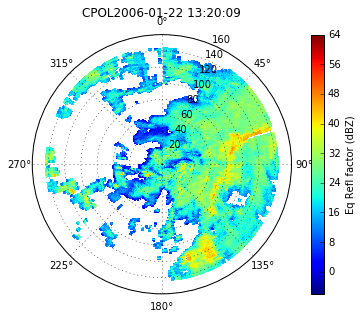

In [14]:

fig = plt.figure()
ax = fig.add_axes([0.0, 0.0, .9, .9],polar=True)
pc=polar_plot(myradar, 1, ax, 'reflectivity')
color_bar = plt.colorbar(mappable=pc)
color_bar.set_label('Eq Refl factor (dBZ)')
plt.savefig('/home/zsherman/Documents/Jupyter/VAD/csapr_dbz_ppi.'+str(datetimes)+'.png', dpi=400)

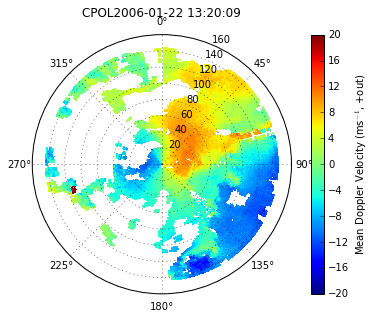

In [15]:
fig = plt.figure()
ax = fig.add_axes([0.0, 0.0, .9, .9],polar=True)
pc=polar_plot(myradar, 1, ax, 'CVD', mask=is_bad, vmin=-20, vmax=20)
color_bar = plt.colorbar(mappable=pc)
color_bar.set_label(r'Mean Doppler Velocity (ms$^{-1}$, +out)')
plt.savefig('/home/zsherman/Documents/Jupyter/VAD/csapr_vel_ppi.'+str(datetimes)+'.png', dpi=400)

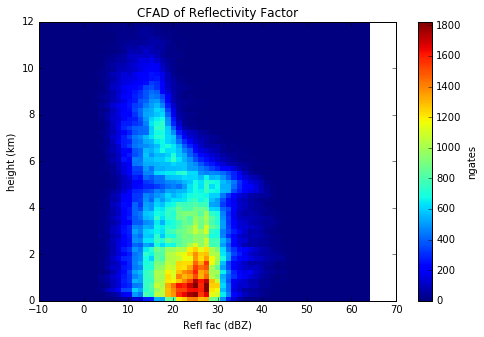

In [16]:
#good=np.where(np.logical_not(is_bad[:,0:-20].flatten()))[0]
good=np.where(np.logical_not(is_bad[:,0:-20].flatten()))[0]
#print(is_bad.shape)
#H, xedges, yedges = np.histogram2d(z[:,0:-20].flatten()[good]/1000.0,
#                    myradar.fields['reflectivity']['data'][:,0:-20].flatten()[good],
#                    bins=(62, 60), range=([0,12], [-10,64]))



h_gram_x = z[:,0:-20].flatten()[good]/1000
h_gram_y = myradar.fields['reflectivity']['data'][:,0:-20].flatten()[good]
h_gram_bins = (62, 60)
h_gram_range = ([0,12], [-10,64])

H, xedges, yedges = np.histogram2d(h_gram_x, h_gram_y, bins=h_gram_bins, range=h_gram_range)
                  

#print(z.shape)

fig = plt.figure(figsize=[8,5])
plt.pcolormesh(yedges, xedges, H)
plt.xlabel('Refl fac (dBZ)'); plt.ylabel('height (km)'); color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.title('CFAD of Reflectivity Factor')
plt.savefig('/home/zsherman/Documents/Jupyter/VAD/cfad_z_'+str(datetimes)+'.png', dpi=200)
plt.show()

In [17]:
z_want=np.linspace(500, 10500, 101)
u_mean, v_mean=VAD(myradar, z_want)

even, all good
max height 2469.09459507
even, all good


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

max height 4231.65790546
even, all good
max height 5954.2626285
even, all good


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

max height 7714.9491356
even, all good
max height 9982.26023244
even, all good


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

max height 12207.7589795
even, all good
max height 14468.9770539
even, all good


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

max height 17192.7706587
even, all good
max height 20684.8287451
even, all good


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

max height 25166.0244245
even, all good
max height 30271.3477816
even, all good


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

max height 36622.6687614
even, all good
max height 44274.1195746
even, all good


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

max height 53494.4003112
even, all good
max height 64213.1225205
even, all good


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

max height 79111.6920095
even, all good
max height 96788.9813151


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3115: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dou

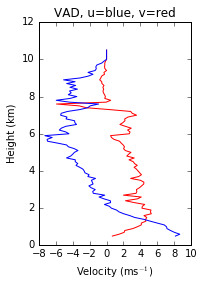

In [18]:
fig=plt.figure()
plt.subplot(1,2,1)
plt.plot(u_mean, z_want/1000.0, 'r-')
plt.plot(v_mean, z_want/1000.0, 'b-')
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
plt.show()

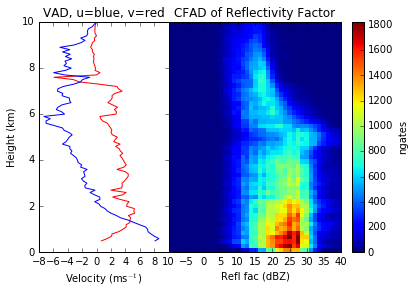

In [19]:
ylims=[0,10]
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.1, .3, .8])
plt.plot(u_mean, z_want/1000.0, 'r-')
plt.plot(v_mean, z_want/1000.0, 'b-')
plt.ylim(ylims)
#ax1.xaxis.set_major_locator(MaxNLocator(prune='upper'))
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
ax2 = fig.add_axes([0.4, 0.1, .5, .8])
plt.pcolormesh(yedges, xedges, H)
plt.ylim(ylims)
plt.xlim([-10,40])
ax2.xaxis.set_major_locator(plt.MaxNLocator(prune='lower'))
ax2.get_yaxis().set_visible(False)
plt.xlabel('Refl fac (dBZ)'); color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.title('CFAD of Reflectivity Factor')
#fig.text(.3,.96,time_str)
plt.savefig('/home/zsherman/Documents/Jupyter/VAD/combo_'+str(datetimes)+'.png', dpi=200)
plt.show()

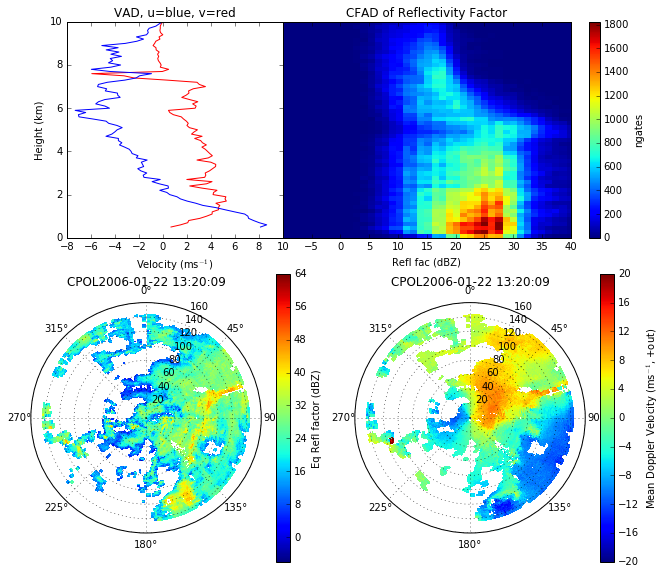

In [20]:
ylims=[0,10]
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_axes([0.1, 0.5, .3, .3])
plt.plot(u_mean, z_want/1000.0, 'r-')
plt.plot(v_mean, z_want/1000.0, 'b-')
plt.ylim(ylims)
#ax1.xaxis.set_major_locator(MaxNLocator(prune='upper'))
plt.xlabel(r'Velocity (ms$^{-1}$)')
plt.ylabel(r'Height (km)')
plt.title('VAD, u=blue, v=red')
ax2 = fig.add_axes([0.4, 0.5, .5, .3])
plt.pcolormesh(yedges, xedges, H)
plt.ylim(ylims)
plt.xlim([-10,40])
ax2.xaxis.set_major_locator(plt.MaxNLocator(prune='lower'))
ax2.get_yaxis().set_visible(False)
plt.xlabel('Refl fac (dBZ)'); color_bar = plt.colorbar()
color_bar.set_label('ngates')
plt.title('CFAD of Reflectivity Factor')
#fig.text(.3,.96,time_str)

ax3 = fig.add_axes([0.05, 0.05, .4, .4],polar=True)
pc=polar_plot(myradar, 1, ax3, 'reflectivity', mask=is_bad)
color_bar=plt.colorbar(mappable=pc)
color_bar.set_label('Eq Refl factor (dBZ)')
plt.savefig('/home/zsherman/Documents/Jupyter/VAD/csapr_dbz_ppi.'+str(datetimes)+'.png', dpi=400)

ax4 = fig.add_axes([0.5, 0.05, .4, .4],polar=True)
pc=polar_plot(myradar, 1, ax4, 'CVD', mask=is_bad, vmin=-20, vmax=20)
color_bar=plt.colorbar(mappable=pc)
color_bar.set_label(r'Mean Doppler Velocity (ms$^{-1}$, +out)')
plt.savefig('/home/zsherman/Documents/Jupyter/VAD/super_combo_'+str(datetimes)+'.png', dpi=200)

In [21]:
filename='/data/manus_rhis/113503.mdv'
myrhi=radar.Radar(py_mdv.read_mdv(filename))

NameError: name 'radar' is not defined

In [ ]:
zr=[0,-120]
yr=[0,14]
nyq = myradar.instrument_parameters['nyquist_velocity']['data'][0]

my_display=radar_display.radar_display(myrhi)
f=figure(figsize=[20,4])
subplot(1,2,1)
my_display.plot_rhi('reflectivity_horizontal',  =vmin=-10, vmax=50.0)
gca().set_title("Hor. Refl. Fac. (dBZ) ")
ylim(yr)
xlim(zr)
my_display.append_x()
my_display.add_cb()
subplot(1,2,2)
my_display.plot_rhi('mean_doppler_velocity', tilt, vmin=-1*nyq, vmax=1*nyq)
gca().set_title("Radial Velocity (m/s)")
ylim(yr)
xlim(zr)
my_display.append_x()
my_display.add_cb()

In [ ]:
zr=[0,-120]
yr=[0,14]
nyq = myradar.instrument_parameters['nyquist_velocity']['data'][0]

display = pyart.graph.RadarDisplay(myradar)
fig=plt.figure(figsize=[20,4])
plt.subplot(1,2,1)
display.plot_rhi('reflectivity', vmin=-10, vmax=50.0)
plt.gca().set_title("Hor. Refl. Fac. (dBZ) ")
plt.ylim(yr)
plt.xlim(zr)

plt.subplot(1,2,2)
display.plot_rhi('CVD', tilt, vmin=-1*nyq, vmax=1*nyq)
plt.gca().set_title("Radial Velocity (m/s)")
plt.ylim(yr)
plt.xlim(zr)

plt.show()

In [ ]:
man_lon=147.0000 #E
mjo_text = np.loadtxt('/home/zsherman/Documents/proj_norm_order.ascii', skiprows=3)
datestr=np.array([str(int(ar[0])) for ar in mjo_text])
I140=np.array([ar[6] for ar in mjo_text])
I160=np.array([ar[7] for ar in mjo_text]) 
datetimes=np.array([datetime(int(datestr[i][0:4]), int(datestr[i][4:6]), int(datestr[i][6::]))
                   for i in range(len(datestr))])
I147=((man_lon- 140.0)*I160 +  (160.0-man_lon)*I140)/ ((160.0-man_lon)+(man_lon- 140.0))

#create more samples for a nicer neg/pos chart
numdates=mdates.date2num(datetimes)
int_obj=scipy.interpolate.interp1d( numdates, I147)
num_dates_want=np.linspace(numdates[0], numdates[-1], 50000)
I147_hr=int_obj(num_dates_want)

print (numdates.shape)

In [ ]:
years   = mdates.YearLocator()   # every year
months  = mdates.MonthLocator()  # every month
days    = mdates.DayLocator(bymonthday=[5,10,15,20,25])
daysFmt = mdates.DateFormatter('%d')
monfmt  = mdates.DateFormatter('%b')
hours   = mdates.HourLocator(byhour=[6,12, 18])
tFmt    = mdates.DateFormatter('%d')

In [ ]:
f=plt.figure(figsize=[10,5])
sup=np.ma.masked_where(I147_hr < 0.0, I147_hr)
act=np.ma.masked_where(I147_hr > 0.0, I147_hr)
plt.fill_between(num_dates_want, act, 0.0, color="blue")#;plot(mdates.date2num(datetimes), I147)
plt.fill_between(num_dates_want, sup, 0.0, color="red")#;plot(mdates.date2num(datetimes), I147)
#fill_between(numdates, I147, 0.0, color="red")
ax=plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(monfmt)
ax.xaxis.set_minor_formatter(daysFmt)
plt.xlabel('Date')
plt.ylabel('MJO Index')
ax.set_xlim((mdates.datestr2num('20110818 0000'), mdates.datestr2num('20111125 0000')))
plt.show()

In [ ]:
ifile = netCDF4.Dataset('/data/manus/manus_time_series.nc','r')
cp_30=ifile.variables['area_above_30dBz'][:]
cp_10=ifile.variables['area_above_10dBz'][:]
cp_05=ifile.variables['area_above_5dBz'][:]

In [ ]:
all_dates = netCDF4.num2date(ifile.variables['time'][:],units=ifile.variables['time'].units)
start_dates=[mdates.datestr2num('20110818 0000'), 
             mdates.datestr2num('20110829 2000'), 
             mdates.datestr2num('20111029 0000'),
             mdates.datestr2num('20111110 1600'), 
             mdates.datestr2num('20111118 0000')]
end_dates=  [mdates.datestr2num('20110828 2320'), 
             mdates.datestr2num('20111029 2320'),
             mdates.datestr2num('20111104 2030'),
             mdates.datestr2num('20111118 0000'),
             mdates.datestr2num('20120101 0000')]

cmap=('gist_ncar')
vmm=[0.0, 10.0]

f=plt.figure(figsize=[20,4])
for i in range(len(start_dates)):
	start_date=start_dates[i]
	end_date=end_dates[i]
	end=list(((mdates.date2num(all_dates)-end_date)**2)).index(((mdates.date2num(all_dates)-end_date)**2).min())
	start=list(((mdates.date2num(all_dates)-start_date)**2)).index(((mdates.date2num(all_dates)-start_date)**2).min())
	dates = netCDF4.num2date(ifile.variables['time'][start:end],units=ifile.variables['time'].units)
	pcolormesh(mdates.date2num(dates),ifile.variables['alt_msl'][:]/1000.0,
               cp_30[start:end,:].transpose()/(2.0*(120.0)**2*pi)*100.0, 
               cmap=cmap , vmin=0, vmax=2.0)
ax=gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(monfmt)
ax.xaxis.set_minor_formatter(daysFmt)
plt.xlabel('Date')
plt.ylabel('height (km)')
plt.title('Percent area where Z>30dBz as observed by CSAPR')
ax.set_ylim([0,14])
#(734280.5, 734283.0)
ax.set_xlim((datestr2num('20110818 0000'), datestr2num('20111125 0000')))

color_bar=plt.colorbar()
color_bar.set_label('Percent Coverage')

plt.savefig('/home/zsherman/Documents/Jupyter/VAD/manus_ts_30.png')

In [ ]:
all_dates = netCDF4.num2date(ifile.variables['time'][:],units=ifile.variables['time'].units)
start_dates=[mdates.datestr2num('20110818 0000'), 
             mdates.datestr2num('20110829 2000'), 
             mdates.datestr2num('20111029 0000'),
             mdates.datestr2num('20111110 1600'), 
             mdates.datestr2num('20111118 0000')]
end_dates=  [mdates.datestr2num('20110828 2320'), 
             mdates.datestr2num('20111029 2320'),
             mdates.datestr2num('20111104 2030'),
             mdates.datestr2num('20111118 0000'),
             mdates.datestr2num('20120101 0000')]

cmap=('gist_ncar')
vmm=[0.0, 10.0]
f=plt.figure(figsize=[20,4])
for i in range(len(start_dates)):
	start_date=start_dates[i]
	end_date=end_dates[i]
	end=list(((mdates.date2num(all_dates)-end_date)**2)).index(((mdates.date2num(all_dates)-end_date)**2).min())
	start=list(((mdates.date2num(all_dates)-start_date)**2)).index(((mdates.date2num(all_dates)-start_date)**2).min())
	dates = netCDF4.num2date(ifile.variables['time'][start:end],units=ifile.variables['time'].units)
	pcolormesh(mdates.date2num(dates),ifile.variables['alt_msl'][:]/1000.0,
               cp_10[start:end,:].transpose()/(2.0*(120.0)**2*pi)*100.0, 
               cmap=cmap , vmin=0, vmax=30.0)
ax=gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(monfmt)
ax.xaxis.set_minor_formatter(daysFmt)
plt.xlabel('Date')
plt.ylabel('height (km)')
plt.title('Percent area where Z>30dBz as observed by CSAPR')
ax.set_ylim([0,14])
#(734280.5, 734283.0)
ax.set_xlim((datestr2num('20110818 0000'), datestr2num('20120101 0000')))

color_bar=plt.colorbar()
color_bar.set_label('Percent Coverage')

plt.savefig('/home/zsherman/Documents/Jupyter/VAD/manus_ts_10.png')


In [ ]:
all_dates = netCDF4.num2date(ifile.variables['time'][:],units=ifile.variables['time'].units)
start_dates_zoom=[mdates.datestr2num('20110915 1600')]
end_dates_zoom=  [mdates.datestr2num('20111005 0000')]

cmap=('gist_ncar')
vmm=[0.0, 10.0]
f=plt.figure(figsize=[20,4])
for i in range(len(start_dates_zoom)):
	start_date=start_dates_zoom[i]
	end_date=end_dates_zoom[i]
	end=list(((mdates.date2num(all_dates)-end_date)**2)).index(((mdates.date2num(all_dates)-end_date)**2).min())
	start=list(((mdates.date2num(all_dates)-start_date)**2)).index(((mdates.date2num(all_dates)-start_date)**2).min())
	dates = netCDF4.num2date(ifile.variables['time'][start:end],units=ifile.variables['time'].units)
	pcolormesh(mdates.date2num(dates),ifile.variables['alt_msl'][:]/1000.0,
               cp_05[start:end,:].transpose()/(2.0*(120.0)**2*pi)*100.0, 
               cmap=cmap , vmin=0, vmax=30.0)
ax=gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[5,10,15,20,25, 30]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xlabel('Date')
plt.ylabel('height (km)')
plt.title('Percent area where Z>5dBz as observed by CSAPR')
ax.set_ylim([0,14])
#(734280.5, 734283.0)
ax.set_xlim((datestr2num('20110915 0000'), datestr2num('20111005 0000')))

color_bar=plt.colorbar()
color_bar.set_label('Percent Coverage')

plt.savefig('/home/zsherman/Documents/Jupyter/VAD/manus_ts_5_zoom.png')

In [ ]:
all_dates = netCDF4.num2date(ifile.variables['time'][:],units=ifile.variables['time'].units)
start_dates_zoom=[mdates.datestr2num('20110915 1600')]
end_dates_zoom=  [mdates.datestr2num('20111005 0000')]

cmap=('gist_ncar')
vmm=[0.0, 10.0]
f=plt.figure(figsize=[20,4])
for i in range(len(start_dates_zoom)):
	start_date=start_dates_zoom[i]
	end_date=end_dates_zoom[i]
	end=list(((mdates.date2num(all_dates)-end_date)**2)).index(((mdates.date2num(all_dates)-end_date)**2).min())
	start=list(((mdates.date2num(all_dates)-start_date)**2)).index(((mdates.date2num(all_dates)-start_date)**2).min())
	dates = netCDF4.num2date(ifile.variables['time'][start:end],units=ifile.variables['time'].units)
	pcolormesh(mdates.date2num(dates),ifile.variables['alt_msl'][:]/1000.0,
               cp_05[start:end,:].transpose()/(2.0*(120.0)**2*pi)*100.0, 
               cmap=cmap , vmin=0, vmax=30.0)
ax=gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:00'))
plt.xlabel('Date')
plt.ylabel('height (km)')
plt.title('Percent area where Z>5dBz as observed by CSAPR')
ax.set_ylim([0,14])
#(734280.5, 734283.0)
ax.set_xlim((datestr2num('20110924 0000'), datestr2num('20110928 0000')))

color_bar=plt.colorbar()
color_bar.set_label('Percent Coverage')

plt.savefig('/home/zsherman/Documents/Jupyter/VAD/manus_ts_5_zoom_other.png')

In [ ]:
all_dates = netCDF4.num2date(ifile.variables['time'][:],units=ifile.variables['time'].units)
start_dates=[mdates.datestr2num('20110818 0000'), 
             mdates.datestr2num('20110829 2000'), 
             mdates.datestr2num('20111029 0000'),
             mdates.datestr2num('20111110 1600'), 
             mdates.datestr2num('20111118 0000')]
end_dates=  [mdates.datestr2num('20110828 2320'), 
             mdates.datestr2num('20111029 2320'),
             mdates.datestr2num('20111104 2030'),
             mdates.datestr2num('20111118 0000'),
             mdates.datestr2num('20120101 0000')]

cmap=('gist_ncar')
vmm=[0.0, 10.0]
f=plt.figure(figsize=[20,4])
for i in range(len(start_dates)):
	start_date=start_dates[i]
	end_date=end_dates[i]
	end=list(((mdates.date2num(all_dates)-end_date)**2)).index(((mdates.date2num(all_dates)-end_date)**2).min())
	start=list(((mdates.date2num(all_dates)-start_date)**2)).index(((mdates.date2num(all_dates)-start_date)**2).min())
	dates = netCDF4.num2date(ifile.variables['time'][start:end],units=ifile.variables['time'].units)
	pcolormesh(mdates.date2num(dates),ifile.variables['alt_msl'][:]/1000.0,
               cp_05[start:end,:].transpose()/(2.0*(120.0)**2*pi)*100.0, 
               cmap=cmap , vmin=0, vmax=30.0)
ax=gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:00'))
plt.xlabel('Date')
plt.ylabel('height (km)')
title('Percent area where Z>5dBz as observed by CSAPR')
ax.set_ylim([0,14])
#(734280.5, 734283.0)
ax.set_xlim((datestr2num('20110901 0000'), datestr2num('20110907 0000')))

color_bar=plt.colorbar()
color_bar.set_label('Percent Coverage')

plt.savefig('/home/zsherman/Documents/Jupyter/VAD/manus_ts_quite.png')

In [ ]:
all_dates = netCDF4.num2date(ifile.variables['time'][:],units=ifile.variables['time'].units)
start_dates=[mdates.datestr2num('20110818 0000'), 
             mdates.datestr2num('20110829 2000'), 
             mdates.datestr2num('20111029 0000'),
             mdates.datestr2num('20111110 1600'), 
             mdates.datestr2num('20111118 0000')]
end_dates=  [mdates.datestr2num('20110828 2320'), 
             mdates.datestr2num('20111029 2320'),
             mdates.datestr2num('20111104 2030'),
             mdates.datestr2num('20111118 0000'),
             mdates.datestr2num('20120101 0000')]

cmap=('gist_ncar')
vmm=[0.0, 10.0]
f=plt.figure(figsize=[15,4])
ax=f.add_axes([0.05, 0.4, .9, .5])
for i in range(len(start_dates)):
	start_date=start_dates[i]
	end_date=end_dates[i]
	end=list(((mdates.date2num(all_dates)-end_date)**2)).index(((mdates.date2num(all_dates)-end_date)**2).min())
	start=list(((mdates.date2num(all_dates)-start_date)**2)).index(((mdates.date2num(all_dates)-start_date)**2).min())
	dates = netCDF4.num2date(ifile.variables['time'][start:end],units=ifile.variables['time'].units)
	pc=ax.pcolormesh(mdates.date2num(dates),ifile.variables['alt_msl'][:]/1000.0,
               cp_05[start:end,:].transpose()/(2.0*(120.0)**2*pi)*100.0, 
               cmap=cmap , vmin=0, vmax=30.0)
ax=gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(monfmt)
ax.xaxis.set_minor_formatter(daysFmt)
plt.xlabel('Date')
plt.ylabel('height (km)')
plt.title('Percent area where Z>5dBz as observed by CSAPR')
ax.set_ylim([0,14])
ax.get_xaxis().set_visible(False)
#(734280.5, 734283.0)
ax.set_xlim((datestr2num('20110818 0000'), datestr2num('20111125 0000')))
axcb=f.add_axes([0.95, 0.4, .03, .5])
color_bar=plt.colorbar(mappable=pc, cax=axcb)
color_bar.set_label('Percent Coverage')

sup=np.ma.masked_where(I147_hr < 0.0, I147_hr)
act=np.ma.masked_where(I147_hr > 0.0, I147_hr)
ax2=f.add_axes([0.05, 0.05, .9, .35])

ax2.fill_between(num_dates_want, act, 0.0, color="blue", label="Enhanced")#;plot(mdates.date2num(datetimes), I147)
ax2.fill_between(num_dates_want, sup, 0.0, color="red", label="Suppressed")#;plot(mdates.date2num(datetimes), I147)
ax2.plot(num_dates_want, act,  color="blue", label="Enhanced")#;plot(mdates.date2num(datetimes), I147)
ax2.plot(num_dates_want, sup, color="red", label="Suppressed")#;plot(mdates.date2num(datetimes), I147)

#fill_between(numdates, I147, 0.0, color="red")
ax2=gca()
ax2.xaxis_date()
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_minor_locator(days)
ax2.xaxis.set_major_formatter(monfmt)
ax2.xaxis.set_minor_formatter(daysFmt)
#ax2.legend(loc=3, ncol=2);
plt.xlabel('Date')
plt.ylabel('MJO Index')
ax2.set_xlim((datestr2num('20110818 0000'), datestr2num('20111125 0000')))
ax2.yaxis.set_major_locator(MaxNLocator(prune='upper'))
ax2.set_ylim([-2,3])
plt.savefig('/home/zsherman/Documents/Jupyter/VAD/manus_ts_05_cool.png')